
### Imports

In [32]:
%pylab inline
import polybin as pb
import healpy
from scipy.interpolate import InterpolatedUnivariateSpline

Populating the interactive namespace from numpy and matplotlib


In [33]:
import importlib
importlib.reload(pb);

### Options

In [ ]:
# HEALPix settings
Nside = 128
lmax = 3*Nside-1

# Binning parameters
dl = 30 # width
Nl = 10 # number
min_l = 2 # minimum
print("binned lmax: %d"%(min_l+dl*Nl))

# Number of random iterations to create Fisher matrix
N_it = 20

# Number of simulations to use for testing
N_sim = 50

# Whether to include bins only partially satisfying triangle conditions
include_partial_triangles = False

# whether to add a separable reduced bispectrum to the input maps
include_synthetic_b = True
b_input_fac = lambda l1: np.exp(-(l1-2)/40.)*2e-6

# Galactic Mask
# Using GAL040 mask with 2-degree apodization for testing
root = '/projects/QUIJOTE/Oliver/planck/'
maskfile = 'HFI_Mask_GalPlane-apo2_2048_R2.00.fits'

### Fiducial Power and Noise Spectrum

In [31]:
from classy import Class
cosmo = Class()

# Define ell arrays
l = np.arange(lmax+1)

# Run CLASS
cosmo.set({'output':'tCl,lCl,mPk','l_max_scalars':lmax+1,'lensing':'yes',
           'omega_b':0.022383,
           'non linear':'no',
           'omega_cdm':0.12011,
           'h':0.6732,
           'm_ncdm':0.06,
           'N_ncdm':1,
           'tau_reio':0.0543,
           'A_s':1e-10*np.exp(3.0448),
           'n_s':0.96605});
cosmo.compute()

# Compute signal C_ell
Cl_dict = cosmo.lensed_cl(lmax);
Cl_th = Cl_dict['tt']*cosmo.T_cmb()**2

# Compute noise C_ell
DeltaT = 60./60.*np.pi/180.*1e-6 # in K-radians
thetaFWHM = 5./60.*np.pi/180. # in radians
Nl_th = DeltaT**2*np.exp(l*(l+1)*thetaFWHM**2/(8.*np.log(2)))*(l>2)

### Load mask

In [ ]:
mask = healpy.ud_grade(healpy.read_map(root+maskfile,field=1),Nside)
healpy.mollview(mask,title='Mask')

### Initialize PolyBin class

In [ ]:
# Load class with fiducial Cl and Nside
base = pb.PolyBin(Nside, Cl_th+Nl_th)

### Generate Synthetic Data with known $C_\ell$, $b_{\ell_1\ell_2\ell_3}$

In [ ]:
# Generate unmasked data with known C_l and factorized b
# Cl is set to the fiducial spectrum unless otherwise specified
# No beam is included
raw_data = base.generate_data(seed=42, add_B=include_synthetic_b, b_input=b_input_fac)

# Mask the map
data = raw_data*mask

# Plot the data
healpy.mollview(data,title='Masked Data')

### Define weighting function (user-set)
- A simple option would be ```applySinv=base.applyUinv```, which matches the code below.
- The idealized estimators just use a $C_{\rm fid}^{-1}$ weighting (which should include noise).

In [2]:
def applySinv(input_map):
    """Apply the optimal weighting to a map. 
    
    Here, we assume that the forward covariance is diagonal, in particular C_l, and invert this.
    This is not quite the exact solution (as it incorrectly treats W(n) factors), but should be unbiased."""
    
    # Transform to harmonic space
    input_map_lm = base.to_lm(input_map)
    # Divide by covariance and return to map-space
    Cinv_map = base.to_map(base.safe_divide(input_map_lm,base.Cl_lm))
    
    return Cinv_map

### Compute Unbinned Power Spectra

In [3]:
# Compute power spectra
av_sq_mask = np.mean(mask**2)
Cl_raw_healpy = healpy.alm2cl(base.to_lm(raw_data))
Cl_healpy = healpy.alm2cl(base.to_lm(data))/av_sq_mask

# Plot results
pref = l*(l+1)/(2.*np.pi)*1e12
plt.plot(l,pref*Cl_raw_healpy,label='Data [unwindowed]',ls='',marker='.',alpha=0.1,c='r')
plt.plot(l,pref*Cl_healpy,label=r'Data [windowed] / $\langle W^2\rangle$',ls='',marker='.',alpha=0.1,c='b')
plt.plot(l,pref*base.Cl,label='Theory',c='k')
plt.xlabel(r'$\ell$',fontsize=15)
plt.legend(fontsize=14)
plt.ylabel(r'$\frac{\ell(\ell+1)}{2\pi}C_\ell^{TT}\,\,[\mu K^2]$',fontsize=15)
plt.xlim([2,lmax])

NameError: name 'mask' is not defined

In [4]:
importlib.reload(pb)
base = pb.PolyBin(Nside,Cl_th+Nl_th)

NameError: name 'pb' is not defined

### Power Spectrum Estimation

Let's compute the binned power spectrum of the map, using both the idealized and optimal estimators. The unwindowed estimator requires a Fisher matrix which we can compute via multiprocessing. Note that the Fisher matrix is independent of the data, thus only needs to be computed once per mask / binning choice.

In [11]:
# Initialize power spectrum class
pspec = pb.PSpec(base, mask, applySinv, min_l, dl, Nl)

Binning: 10 bins in [2, 302]


In [12]:
# Compute Fisher matrix on 4 CPUs
fish = pspec.compute_fisher(N_it, N_cpus=4);

# Compute unwindowed power spectrum
Cl_opt = pspec.Cl_unwindowed(data, fish=fish)

Computing Fisher contribution from 20 Monte Carlo simulations on 4 threads


100%|██████████| 20/20 [00:28<00:00,  1.45s/it]


Alternatively, we can assemble the Fisher matrix by hand (e.g., if we wish to distribute between many nodes). Then we just need to pass it to the estimator.

In [13]:
# Iterate by hand
fish = 0.
for i in range(N_it):
    if i%5==0: print("On iteration %d of %d"%(i+1,N_it))
    fish += pspec.compute_fisher_contribution(i)/N_it

# Compute unwindowed power spectrum, passing the Fisher matrix
Cl_opt = pspec.Cl_unwindowed(data, fish=fish)

On iteration 1 of 20
On iteration 6 of 20
On iteration 11 of 20
On iteration 16 of 20


Let's also compute the idealized binned power spectrum and plot the results, noting that the final bin or two will be biased since we ignore the correlations with the higher bins. These would be excluded in any real analysis.

We also plot the Fisher matrix, which shows how correlated individual bins are as a result of the window. Note that the covariance matrix is the inverse of the Fisher matrix. 

In [14]:
# Compute unwindowed power spectrum, passing the Fisher matrix
Cl_ideal = pspec.Cl_ideal(data)

Computing ideal Fisher matrix


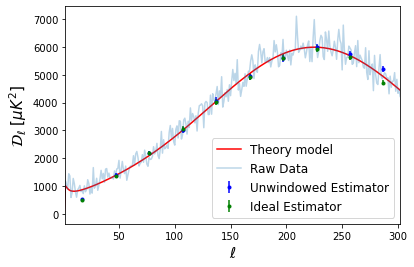

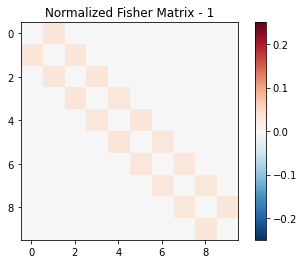

In [15]:
l_av = np.asarray([min_l+dl/2+dl*bin1 for bin1 in range(Nl)])
pref_av = l_av*(l_av+1.)/(2.*np.pi)*1e12

fish_err = np.sqrt(np.diag(pspec.inv_fish))
fish_err_ideal = np.sqrt(np.diag(pspec.inv_fish_ideal))*np.sqrt(np.mean(mask**4.)/np.mean(mask**2)**2)

# Plot spectra
plt.errorbar(l_av,pref_av*Cl_opt,yerr=pref_av*fish_err,marker='.',ls='',label='Unwindowed Estimator',c='b')
plt.errorbar(l_av,pref_av*Cl_ideal,yerr=pref_av*fish_err_ideal,marker='.',ls='',label='Ideal Estimator',c='g')
plt.plot(l,pref*Cl_th,label='Theory model',c='r')
plt.plot(l,pref*Cl_raw_healpy,label='Raw Data',alpha=0.3)
plt.xlim([min_l,min_l+dl*Nl])
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\mathcal{D}_\ell\,\,[\mu K^2]$',fontsize=15)
plt.legend(fontsize=12)

# Plot correlation matrix
plt.figure()
corr_fish = fish/np.sqrt(np.outer(np.diag(fish),np.diag(fish)))
v = 0.25
plt.imshow(corr_fish-np.eye(len(corr_fish)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
plt.title("Normalized Fisher Matrix - 1")
plt.colorbar();

### Iterate over multiple data-sets
Let's test whether the estimator is minimum variance by iterating over GRF datasets. This is fast, since we don't need to recompute the Fisher matrix!

In [16]:
Cl_unwindowed_all = []
Cl_ideal_all = []
Cl_raw_all = []

for ii in range(N_sim):
    if ii%10==0: 
        print("Analyzing simulation %d of %d"%(ii+1,N_sim))
    
    # Generate data (pure GRFs here)
    raw_sim = base.generate_data(ii,add_B=False)
    sim = mask*raw_sim
    
    # Compute binned and unbinned power spectra
    Cl_unwindowed_all.append(pspec.Cl_unwindowed(sim))
    Cl_ideal_all.append(pspec.Cl_ideal(sim))
    Cl_raw_all.append(healpy.anafast(raw_sim))

Analyzing simulation 1 of 50
Analyzing simulation 11 of 50
Analyzing simulation 21 of 50
Analyzing simulation 31 of 50
Analyzing simulation 41 of 50


Below, we plot the results. Importantly, the variance of the unwindowed estimator matches its Fisher matrix - i.e. it is optimal! However, it looks like the idealized estimator has a *lower* variance? This is due to the off-diagonal correlations imposed by the window function, as seen in the correlation matrices.

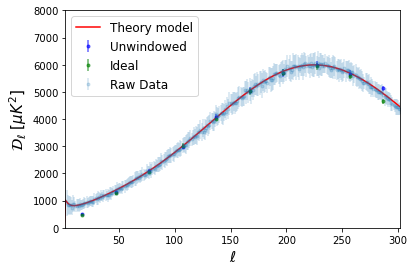

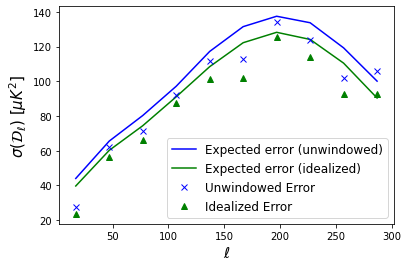

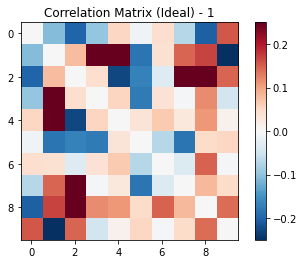

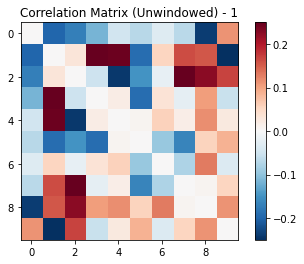

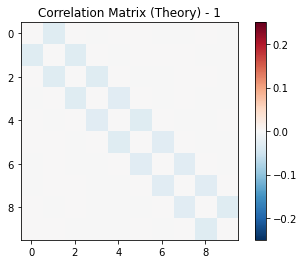

In [17]:
l_av = np.asarray([min_l+dl/2+dl*bin1 for bin1 in range(Nl)])
pref_av = l_av*(l_av+1.)/(2.*np.pi)*1e12

fish_err = np.sqrt(np.diag(pspec.inv_fish))
fish_err_ideal = np.sqrt(np.diag(pspec.inv_fish_ideal))*np.sqrt(np.mean(mask**4)/np.mean(mask**2)**2)
plt.errorbar(l_av,pref_av*np.asarray(Cl_unwindowed_all).mean(axis=0),yerr=pref_av*fish_err,marker='.',ls='',label='Unwindowed',c='b',alpha=0.6)
plt.errorbar(l_av,pref_av*np.asarray(Cl_ideal_all).mean(axis=0),yerr=pref_av*fish_err_ideal,marker='.',ls='',label='Ideal',c='g',alpha=0.6)
plt.plot(l,pref*Cl_th,label='Theory model',c='r')
plt.errorbar(l,pref*np.asarray(Cl_raw_all).mean(axis=0),yerr=pref*np.asarray(Cl_raw_all).std(axis=0),
             ls='',marker='.',label='Raw Data',alpha=0.2)
plt.xlim([0,lmax])
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\mathcal{D}_\ell\,\,[\mu K^2]$',fontsize=15)
plt.legend(fontsize=12)
plt.ylim([0,8000])
plt.xlim([min_l,min_l+Nl*dl])

plt.figure()
plt.plot(l_av,pref_av*fish_err,label='Expected error (unwindowed)',c='b')
plt.plot(l_av,pref_av*fish_err_ideal,label='Expected error (idealized)',c='g')
plt.plot(l_av,pref_av*np.asarray(Cl_unwindowed_all).std(axis=0),label='Unwindowed Error',c='b',marker='x',ls='')
plt.plot(l_av,pref_av*np.asarray(Cl_ideal_all).std(axis=0),label='Idealized Error',c='g',marker='^',ls='')
plt.xlabel(r'$\ell$',fontsize=15)
plt.legend(fontsize=12)
plt.ylabel(r'$\sigma(\mathcal{D}_\ell)\,\,[\mu K^2]$',fontsize=15);
plt.xlim([min_l,min_l+Nl*dl]);

# Plot correlation matrices
cov_ideal = np.cov(np.asarray(Cl_ideal_all).T)
corr_ideal = cov_ideal/np.sqrt(np.outer(np.diag(cov_ideal),np.diag(cov_ideal)))
cov_unwindowed = np.cov(np.asarray(Cl_unwindowed_all).T)
corr_unwindowed = cov_unwindowed/np.sqrt(np.outer(np.diag(cov_unwindowed),np.diag(cov_unwindowed)))
cov_theory = np.linalg.inv(pspec.fish)
corr_theory = cov_theory/np.sqrt(np.outer(np.diag(cov_theory),np.diag(cov_theory)))

plt.figure()
v = 0.25
plt.imshow(corr_ideal-np.eye(len(corr_ideal)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
plt.title("Correlation Matrix (Ideal) - 1")
plt.colorbar();

plt.figure()
plt.imshow(corr_unwindowed-np.eye(len(corr_unwindowed)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
plt.title("Correlation Matrix (Unwindowed) - 1")
plt.colorbar();

plt.figure()
plt.imshow(corr_theory-np.eye(len(corr_theory)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
plt.title("Correlation Matrix (Theory) - 1")
plt.colorbar();

# Bispectrum estimation

In [18]:
importlib.reload(pb)
base = pb.PolyBin(Nside,Cl_th+Nl_th)

In [19]:
# Initialize bispectrum class
bspec = pb.BSpec(base, mask, applySinv, min_l, dl, Nl)

Binning: 10 bins in [2, 302]


In [20]:
b_ideal = bspec.Bl_ideal(data)

Computing ideal Fisher matrix
Using 125 bispectrum bins


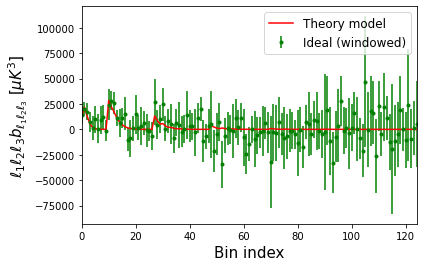

In [21]:
weights = []
bl_model = []
for bin1 in range(Nl):
    for bin2 in range(bin1,Nl):
        for bin3 in range(bin2,Nl):
            # skip bins outside the triangle conditions
            if not bspec._check_bin(bin1,bin2,bin3): continue
            weights.append((min_l+(bin1+0.5)*dl)*(min_l+(bin2+0.5)*dl)*(min_l+(bin3+0.5)*dl)*1e18)
            bl_model.append(b_input_fac(min_l+(bin1+0.5)*dl)*b_input_fac(min_l+(bin2+0.5)*dl)*b_input_fac(min_l+(bin3+0.5)*dl))
weights = np.asarray(weights)
bl_model = np.asarray(bl_model)
            
fish_err_ideal = np.sqrt(np.diag(bspec.inv_fish_ideal))*np.mean(mask**6)/np.mean(mask**3)**2

plt.errorbar(np.arange(bspec.N_b),weights*b_ideal,yerr=weights*fish_err_ideal,marker='.',ls='',label='Ideal (windowed)',c='g')
plt.plot(np.arange(bspec.N_b),weights*bl_model,label='Theory model',c='r')
plt.xlim([0,bspec.N_b-1])
plt.xlabel(r'Bin index',fontsize=15)
plt.ylabel(r'$\ell_1\ell_2\ell_3b_{\ell_1\ell_2\ell_3}\,\,[\mu K^3]$',fontsize=15)
plt.legend(fontsize=12)

### Window-free estimator

In [22]:
# Generate MC simulations
bspec.generate_sims(N_it,b_input=b_input_fac,add_B=True,remove_mean=True)

# # Alternatively, read-in MC simulations created externally
# alpha_sims = []
# for ii in range(N_it):
#     alpha = base.generate_data(seed=10000+ii,add_B=include_synthetic_b, b_input=b_input_fac)
#     alpha_sims.append(alpha)
# bspec.load_sims(alpha_sims, verb=True)

Using 20 Monte Carlo simulations
Computing offset for synthetic maps


In [23]:
fish = bspec.compute_fisher(N_it, N_cpus=4)

Computing Fisher contribution from 20 Monte Carlo simulations on 4 threads


100%|██████████| 20/20 [07:56<00:00, 23.83s/it]


In [24]:
b_unwindowed = bspec.Bl_unwindowed(data, verb=True, include_linear_term=True)

Computing b_3 piece
Computing b_1 piece from simulation 5
Computing b_1 piece from simulation 10
Computing b_1 piece from simulation 15
Computing b_1 piece from simulation 20


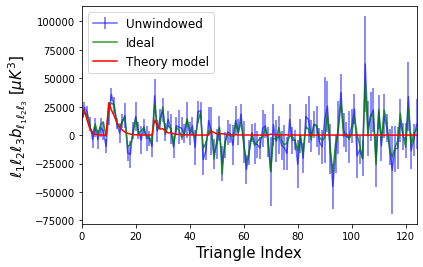

In [25]:
fish_err = np.sqrt(np.diag(np.linalg.inv(bspec.fish)))
plt.errorbar(np.arange(bspec.N_b),weights*b_unwindowed,yerr=weights*fish_err,label='Unwindowed',c='b',alpha=0.6)
plt.errorbar(np.arange(bspec.N_b),weights*b_ideal,label='Ideal',c='g',alpha=0.8)
if include_synthetic_b:
    plt.errorbar(np.arange(bspec.N_b),weights*bl_model,label='Theory model',c='r')
else:
    plt.errorbar(np.arange(bspec.N_b),0.*weights*bl_model,label='Theory model',c='r')
plt.legend(fontsize=12)
plt.xlim([0,bspec.N_b-1])
plt.xlabel("Triangle Index",fontsize=15)
plt.ylabel(r"$\ell_1\ell_2\ell_3 b_{\ell_1\ell_2\ell_3}\,\,[\mu K^3]$",fontsize=15);

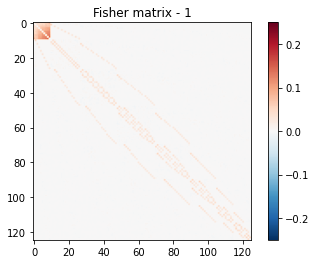

In [26]:
corr_fish_b = bspec.fish/np.sqrt(np.outer(np.diag(bspec.fish),np.diag(bspec.fish)))
v = 0.25
plt.imshow(corr_fish_b-np.eye(len(corr_fish_b)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
plt.title("Fisher matrix - 1")
plt.colorbar();

### Iterate over multiple datasets

In [27]:
b_unwindowed_all = []
b_ideal_all = []

for jj in range(N_sim):
    
    if jj%10==0: 
        print("Analyzing simulation %d of %d"%(jj+1,N_sim))

    # Generate unmasked data
    data = mask*base.generate_data(jj,add_B=include_synthetic_b, b_input=b_input_fac)

    b_ideal_all.append(bspec.Bl_ideal(data))
    b_unwindowed_all.append(bspec.Bl_unwindowed(data,verb=False))

Analyzing simulation 1 of 50
Analyzing simulation 11 of 50
Analyzing simulation 21 of 50
Analyzing simulation 31 of 50
Analyzing simulation 41 of 50


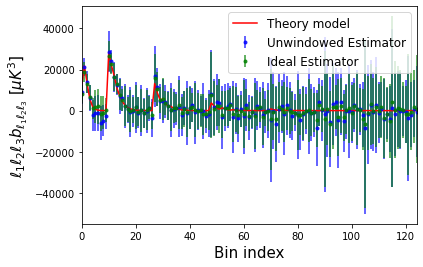

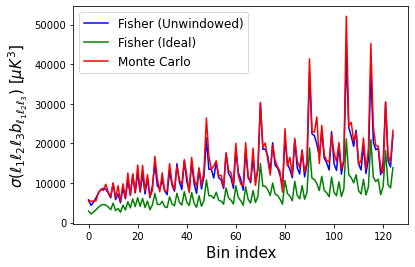

In [28]:
fish_err = np.sqrt(np.diag(bspec.inv_fish))
fish_err_ideal = np.sqrt(np.diag(bspec.inv_fish_ideal))

plt.errorbar(np.arange(bspec.N_b),weights*np.asarray(b_unwindowed_all).mean(axis=0),yerr=weights*fish_err,marker='.',ls='',label='Unwindowed Estimator',c='b',alpha=0.8)
plt.plot(np.arange(bspec.N_b),weights*bl_model,label='Theory model',c='r')
plt.errorbar(np.arange(bspec.N_b),weights*np.asarray(b_ideal_all).mean(axis=0),yerr=weights*np.asarray(b_ideal_all).std(axis=0),
             ls='',marker='.',label='Ideal Estimator',alpha=0.8,c='g')
plt.xlim([0,bspec.N_b-1])
plt.xlabel(r'Bin index',fontsize=15)
plt.ylabel(r'$\ell_1\ell_2\ell_3b_{\ell_1\ell_2\ell_3}\,\,[\mu K^3]$',fontsize=15)
plt.legend(fontsize=12)

plt.figure()
plt.plot(np.arange(bspec.N_b),weights*fish_err,label='Fisher (Unwindowed)',c='b')
plt.plot(np.arange(bspec.N_b),weights*fish_err_ideal,label=r'Fisher (Ideal)',c='g')
plt.plot(np.arange(bspec.N_b),weights*np.asarray(b_unwindowed_all).std(axis=0),label='Monte Carlo',c='r')
plt.xlabel(r'Bin index',fontsize=15)
plt.legend(fontsize=12)
plt.ylabel(r'$\sigma(\ell_1\ell_2\ell_3b_{\ell_1\ell_2\ell_3})\,\,[\mu K^3]$',fontsize=15);

# Trispectrum Estimation

We now consider the trispectrum. Since trispectrum estimation is considerably more expensive, we'll use a broader binning here. In general, calculations would be performed on a cluster, but we'll pick a small problem below for testing on a single computer.

In [32]:
%pylab inline
import healpy
import polybin as pb
from scipy.interpolate import InterpolatedUnivariateSpline

# HEALPix settings
Nside = 128
lmax = 3*Nside-1

# Binning parameters
dl = 30 # width
Nl = 10 # number
min_l = 2 # minimum
print("binned lmax: %d"%(min_l+dl*Nl))

# Number of random iterations to create Fisher matrix
N_it = 20

# Number of simulations to use for testing
N_sim = 50

# Whether to include bins only partially satisfying triangle conditions
include_partial_triangles = False

# whether to add a separable reduced bispectrum to the input maps
include_synthetic_b = True
b_input_fac = lambda l1: np.exp(-(l1-2)/40.)*2e-6

# Galactic Mask
# Using GAL040 mask with 2-degree apodization for testing
root = '/projects/QUIJOTE/Oliver/planck/'
maskfile = 'HFI_Mask_GalPlane-apo2_2048_R2.00.fits'

from classy import Class
cosmo = Class()

# Define ell arrays
l = np.arange(lmax+1)

# Run CLASS
cosmo.set({'output':'tCl,lCl,mPk','l_max_scalars':lmax+1,'lensing':'yes',
           'omega_b':0.022383,
           'non linear':'no',
           'omega_cdm':0.12011,
           'h':0.6732,
           'm_ncdm':0.06,
           'N_ncdm':1,
           'tau_reio':0.0543,
           'A_s':1e-10*np.exp(3.0448),
           'n_s':0.96605});
cosmo.compute()

# Compute signal C_ell
Cl_dict = cosmo.lensed_cl(lmax);
Cl_th = Cl_dict['tt']*cosmo.T_cmb()**2

# Compute noise C_ell
DeltaT = 60./60.*np.pi/180.*1e-6 # in K-radians
thetaFWHM = 5./60.*np.pi/180. # in radians
Nl_th = DeltaT**2*np.exp(l*(l+1)*thetaFWHM**2/(8.*np.log(2)))*(l>2)

mask = healpy.ud_grade(healpy.read_map(root+maskfile,field=1),Nside)

# print("REMOVING MASK")
# mask = np.ones_like(mask)

# Load class
base = pb.PolyBin(Nside,Cl_th+Nl_th)

# Generate unmasked data with known C_l and factorized b
# Cl is set to the fiducial spectrum unless otherwise specified
# No beam is included
raw_data = base.generate_data(seed=42, add_B=include_synthetic_b, b_input=b_input_fac)

# Mask the map
data = raw_data*mask

def applySinv(input_map):
    """Apply the optimal weighting to a map. 
    
    Here, we assume that the forward covariance is diagonal, in particular C_l, and invert this.
    This is not quite the exact solution (as it incorrectly treats W(n) factors), but should be unbiased."""
    
    # Transform to harmonic space
    input_map_lm = base.to_lm(input_map)
    # Divide by covariance and return to map-space
    Cinv_map = base.to_map(base.safe_divide(input_map_lm,base.Cl_lm))
    
    return Cinv_map

Populating the interactive namespace from numpy and matplotlib
binned lmax: 302
Computing offset for synthetic maps


In [33]:
# Initialize trispectrum class
min_l = 10
dl = 20
Nl = 4
tspec = pb.TSpec(base, mask, applySinv, min_l, dl, Nl)

Binning: 4 bins in [10, 90]


In [ ]:
fish_odd = tspec.compute_fisher(1,parity='odd',N_cpus=1,verb=True)

Using 121 odd-parity trispectrum bins
Computing Fisher contribution 1 of 1

Generating data

Creating H maps for S-inverse-weighted fields
Computing A[u1,u2] maps for S-inverse-weighted fields
Computing raw Q maps for S-inverse-weighted fields
Assembling Q filters for S-inverse-weighted fields

Creating H maps for U-inverse-weighted fields
Computing A[u1,u2] maps for U-inverse-weighted fields
Computing raw Q maps for U-inverse-weighted fields
Assembling Q filters for U-inverse-weighted fields

Computing Fisher matrix contribution
On bin 1 of 121
On bin 6 of 121
On bin 11 of 121
On bin 16 of 121


In [ ]:
tspec.generate_sims(10)

In [ ]:
t_odd = tspec.Tl_unwindowed(data,parity='odd',verb=True)

In [ ]:
ff = np.abs(fish_odd)
corr_fish = ff/np.sqrt(np.outer(np.diag(ff),np.diag(ff)))
plt.imshow(corr_fish,vmax=1,vmin=-1);
plt.colorbar();

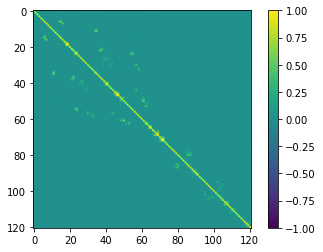

In [24]:
ff = np.abs(fish_odd)
corr_fish = ff/np.sqrt(np.outer(np.diag(ff),np.diag(ff)))
plt.imshow(corr_fish,vmax=1,vmin=-1);
plt.colorbar();

In [ ]:
plt.plot(-np.diag(fish_odd))

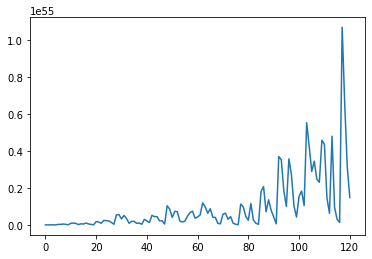

In [22]:
plt.plot(-np.diag(fish_odd))

In [ ]:
plt.errorbar(np.arange(tspec.N_t_odd),t_odd.imag,yerr=np.sqrt(-np.diag(tspec.inv_fish_odd)),ls='',marker='.')

<ErrorbarContainer object of 3 artists>

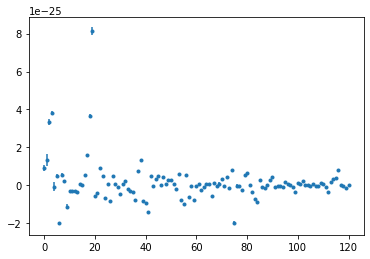

In [31]:
plt.errorbar(np.arange(tspec.N_t_odd),t_odd.imag,yerr=np.sqrt(-np.diag(tspec.inv_fish_odd)),ls='',marker='.')

In [16]:
t_odd2 = t_odd.copy()

In [36]:
fish_odd = tspec.compute_fisher_contribution(242,parity='odd',verb=True)

Using 35 odd-parity trispectrum bins
Generating data
Creating H maps for S-inverse-weighted fields
Computing A[u1,u2] maps for S-inverse-weighted fields

Computing raw Q maps for S-inverse-weighted fields
Assembling Q filters for S-inverse-weighted fields
Creating H maps for U-inverse-weighted fields
Computing A[u1,u2] maps for U-inverse-weighted fields

Computing raw Q maps for U-inverse-weighted fields
Assembling Q filters for U-inverse-weighted fields
Computing Fisher matrix contribution
On bin 1 of 35
On bin 6 of 35
On bin 11 of 35
On bin 16 of 35
On bin 21 of 35
On bin 26 of 35
On bin 31 of 35


In [37]:
fish_even = tspec.compute_fisher_contribution(242,parity='even',verb=True)

Using 51 even-parity trispectrum bins
Generating data
Creating H maps for S-inverse-weighted fields
Computing A[u1,u2] maps for S-inverse-weighted fields

Computing raw Q maps for S-inverse-weighted fields
Assembling Q filters for S-inverse-weighted fields
Creating H maps for U-inverse-weighted fields
Computing A[u1,u2] maps for U-inverse-weighted fields

Computing raw Q maps for U-inverse-weighted fields
Assembling Q filters for U-inverse-weighted fields
Computing Fisher matrix contribution
On bin 1 of 51
On bin 6 of 51
On bin 11 of 51
On bin 16 of 51
On bin 21 of 51
On bin 26 of 51
On bin 31 of 51
On bin 36 of 51
On bin 41 of 51
On bin 46 of 51
On bin 51 of 51


In [38]:
fish_both = tspec.compute_fisher_contribution(242,parity='both',verb=True)

Generating data
Creating H maps for S-inverse-weighted fields
Computing A[u1,u2] maps for S-inverse-weighted fields

Computing raw Q maps for S-inverse-weighted fields
Assembling Q filters for S-inverse-weighted fields
Creating H maps for U-inverse-weighted fields
Computing A[u1,u2] maps for U-inverse-weighted fields

Computing raw Q maps for U-inverse-weighted fields
Assembling Q filters for U-inverse-weighted fields
Computing Fisher matrix contribution
On bin 1 of 51
On bin 6 of 51
On bin 11 of 51
On bin 16 of 51
On bin 21 of 51
On bin 26 of 51
On bin 31 of 51
On bin 36 of 51
On bin 41 of 51
On bin 46 of 51
On bin 51 of 51


### no mask here!

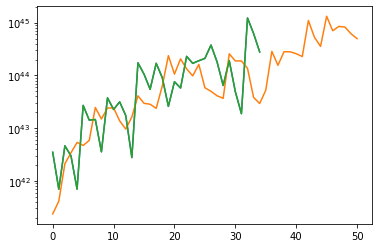

In [39]:
plt.plot(np.abs(np.diag(fish_both)[tspec.N_t_even:]))
plt.plot(np.diag(fish_even))
plt.plot(-np.diag(fish_odd))
plt.yscale('log')

### a) window is weird??

### b) off-diagonal is weird - should asymptote to zero?

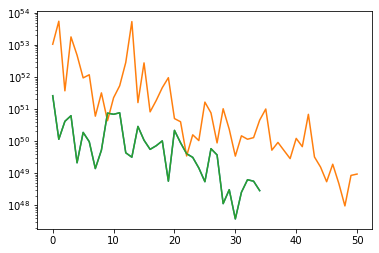

In [20]:
plt.plot(np.abs(np.diag(fish_both)[tspec.N_t_even:]))
plt.plot(np.diag(fish_even))
plt.plot(-np.diag(fish_odd))
plt.yscale('log')

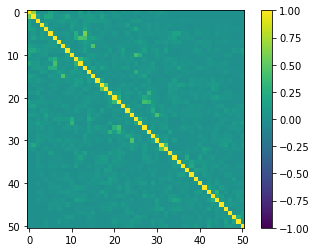

In [40]:
ff = np.abs(fish_even)
corr_fish = ff/np.sqrt(np.outer(np.diag(ff),np.diag(ff)))
plt.imshow(corr_fish,vmax=1,vmin=-1);
plt.colorbar();

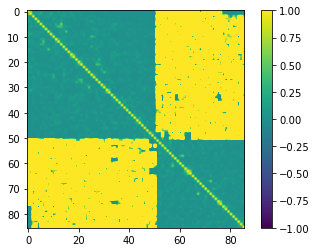

In [43]:
ff = np.abs(fish_both)
corr_fish = ff/np.sqrt(np.outer(np.diag(ff),np.diag(ff)))
plt.imshow(corr_fish,vmax=1,vmin=-1);
plt.colorbar();

In [47]:
tspec.generate_sims(10,Cl_th+Nl_th)

Using 10 Monte Carlo simulations


In [48]:
t_unwindowed_even = tspec.Tl_numerator(data,parity='both',verb=True)

Computing t0 term
Computing t0 term
Computing H^+- maps
Computing A maps
Computing A maps for cross-spectra
Assembling parity-even trispectrum numerator
Assembling parity-odd trispectrum numerator


### cross-terms don't seem to work yet??
### check there's the same symmetry there!

### could check just with a constant window that there's no effects?

## can we use transpose symmetry to drop half the Fisher matrix bins? force index2>index1?

## switch to just computing Im part of trispectrum?
## also helps in Fisher?

In [3]:
t_even, t_odd = tspec.Tl_ideal(data,parity='both',verb=True)

Computing ideal Fisher matrix
Using 51 even-parity trispectrum bins
Using 35 odd-parity trispectrum bins
Computing bin 5 of 51
Computing bin 10 of 51
Computing bin 15 of 51
Computing bin 20 of 51
Computing bin 25 of 51
Computing bin 30 of 51
Computing bin 35 of 51
Computing bin 40 of 51
Computing bin 45 of 51
Computing bin 50 of 51
Computing numerator
Computing H^+- maps
Computing A maps
Assembling parity-even trispectrum numerator
Assembling parity-odd trispectrum numerator


In [4]:
t_even2 = tspec.Tl_ideal(data,parity='even',verb=True)

Using precomputed Fisher matrix
Computing numerator
Computing H^+- maps
Computing A maps
Assembling parity-even trispectrum numerator
